    Area Health Resources File

Imports and Variables

In [577]:
import pandas as pd
import numpy as np
import geopandas
import matplotlib.colors as colors
import math
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import plotly.express as px

from module.variables import *
from module.functions import *

import pickle


Load Data and Functions

In [578]:
# USA Provider Information for Each State
yr_21 = pd.read_csv("Providers/AHRFDashboard_20-21.csv", skiprows = 2).drop("Source", axis = 1).rename(columns={"State/Territory":"NAME", "M.D., Ophthalmology (County Level File)":"Ophthalmologists_21", "Population, All (County Level File)":"Pop_21", "Rate (per 100,000 population)":"Rate_100k_21_Ophtho"}).loc[0:53, :]
yr_20 = pd.read_csv("Providers/AHRFDashboard_19_20.csv", skiprows = 2).drop("Source", axis = 1).rename(columns={"State/Territory":"NAME", "M.D., Ophthalmology (County Level File)":"Ophthalmologists_20", "Population, All (County Level File)":"Pop_20", "Rate (per 100,000 population)":"Rate_100k_20_Ophtho"}).loc[0:53, :]
yr_19 = pd.read_csv("Providers/AHRFDashboard_18_19.csv", skiprows = 2).drop("Source", axis = 1).rename(columns={"State/Territory":"NAME", "M.D., Ophthalmology (County Level File)":"Ophthalmologists_19", "Population, All (County Level File)":"Pop_19", "Rate (per 100,000 population)":"Rate_100k_19_Ophtho"}).loc[0:53, :]

#All MDs for the USA
all_providers = pd.read_csv('all_md.csv')
for index, row in all_providers.iterrows():
    pop = int("".join([x for x in row["Pop_22"] if x != ","]))
    MD = float("".join([x for x in row["MD_22"] if x != ","]))
    all_providers.loc[index,"Pop_22"] = pop
    all_providers.loc[index,"MD_22"] = MD
all_providers["Pop_22"] = all_providers["Pop_22"].astype(float)
all_providers["MD_22"] = all_providers["MD_22"].astype(float)

#Ophthalmology residents in the USA by state
residents = pd.read_csv("Residency.csv", header = None)

In [579]:
with open('fellowships_by_state.pickle', 'rb') as handle:
    fellowships_by_state = pickle.load(handle)


fellowships = set([])
for x in fellowships_by_state:
    for y in fellowships_by_state[x]:
        fellowships.add(y)

fellowships = list(fellowships)


fellowship_pd = pd.DataFrame(columns= ["NAME"] + fellowships)

for x in fellowships_by_state:
    temp = pd.DataFrame(columns=["NAME"] + fellowships)
    temp.loc[0, "NAME"] = x
    for y in fellowships_by_state[x]:
        temp.loc[0, y] = fellowships_by_state[x][y]
    fellowship_pd = pd.concat([fellowship_pd, temp])

renames = {}
for x in fellowship_pd.columns:
    if x != "NAME":
        renames[x] = x + "_fellowship"
    # print(x + "_fellowship")

fellowship_pd = fellowship_pd.rename(columns = {"Total": "Total_Fellowship"})
fellowship_pd = fellowship_pd.rename(columns = renames)
fellowship_pd = fellowship_pd.sort_values(by="Total_Fellowship", ascending = False)
fellowship_pd =  fellowship_pd.fillna(0)
# fellowship_pd

In [580]:
with open('specialty_state_positions.pickle', 'rb') as handle:
    residency_state = pickle.load(handle)


residents_all = pd.DataFrame(0 ,columns= list(residency_state.keys()) + ["All"], index=state_salaries)
for s in residency_state:
    for state in residency_state[s]:
        if state in state_salaries:
            residents_all.loc[state,"All"] +=  residency_state[s][state]
            residents_all.loc[state,s] =  residency_state[s][state]


residents_ophtho_all = residents_all.loc[:, ["Ophthalmology", "All"]]
residents_ophtho_all.reset_index(inplace=True)
residents_ophtho_all = residents_ophtho_all.rename(columns = {'index':'STUSPS'})
residents_ophtho_all = residents_ophtho_all.rename(columns = {'Ophthalmology':'Ophtho_Residents'})

In [581]:
#Formats the resident data for USA ophtho
residents.columns = ["NAME"]
residents["Ophtho_Residents"] = 0

for x in residents["NAME"]:
    y = x.split(" ")
    if len(y) == 3:
        state = y[0] + " " + y[1]
    else:
        state = y[0]
    number = y[-1]
    number = int(number[1:-1])
    residents.loc[residents["NAME"] == x, "Ophtho_Residents"] = number
    residents.loc[residents["NAME"] == x, "NAME"] = state

In [582]:
#Create DataFrames for Salaries for Each State
salaries_df = pd.DataFrame([state_salaries, salaries]).T
salaries_df.columns = ["STUSPS", "Salaries"]

Structure Data

In [583]:
#Pull all salary data and interest level data for the states of interest
state_to_state = pull_all(10, [2020, 2021], state_salaries, "COVID").mean()
state_to_state = pd.DataFrame(state_to_state, columns = ["Interest_21"])
state_to_state["Interest_20"] = pull_all(10, [2019, 2020], state_salaries, "COVID").mean()
state_to_state["Interest_19"] = pull_all(10, [2018, 2019], state_salaries, "COVID").mean()
state_to_state["STUSPS"] = state_to_state.index
state_to_state = state_to_state.merge(salaries_df, on="STUSPS")
state_to_state["Salaries"] = state_to_state["Salaries"].astype('float')

In [584]:
all_conditions = pull_all(10, [2020, 2021], state_salaries, "COVID").T
renames = {}
for x in all_conditions.columns:
    renames[x] = x + "_interest"
    print(x + "_interest")
all_conditions = all_conditions.rename(columns = renames)
all_conditions["STUSPS"] = all_conditions.index


glaucoma_interest
cataract_interest
diabetic retinopathy_interest
macular degeneration_interest
uveitis_interest


In [585]:
#Combine it with provider level information and geography plots
states = geopandas.read_file('data/usa-states-census-2014.shp')
states = states.drop_duplicates()
states = states.merge(state_to_state, on="STUSPS", how='left')
states = states.merge(yr_21, on="NAME", how='left')
states = states.merge(yr_20, on="NAME", how='left')
states = states.merge(yr_19, on="NAME", how='left')
states = states.merge(all_providers, on="NAME", how='left')
states = states.merge(fellowship_pd, on="NAME", how='left')
states = states.merge(residents_ophtho_all, on="STUSPS", how='left')
states = states.merge(all_conditions, on="STUSPS", how='left')
states['Ophtho_Residents'] = states['Ophtho_Residents'].fillna(0)
states['glaucoma_interest'] = states['glaucoma_interest'].fillna(0)
states['cataract_interest'] = states['cataract_interest'].fillna(0)
states['diabetic retinopathy_interest'] = states['diabetic retinopathy_interest'].fillna(0)
states['macular degeneration_interest'] = states['macular degeneration_interest'].fillna(0)
states['uveitis_interest'] = states['uveitis_interest'].fillna(0)
states = states.sort_values(by=['NAME'])
states = states.fillna(0)
print(states["Ophthalmologists_21"])
print(states["Ophtho_Residents"])
print(states["Ophthalmologists_21"]/states["Ophtho_Residents"])


41     231.0
19     318.0
20     129.0
0     2454.0
21     302.0
23     278.0
39      37.0
1       97.0
2     1328.0
3      469.0
4       68.0
5      751.0
22     257.0
6      162.0
45     156.0
7      210.0
8      337.0
28      69.0
9      556.0
29     607.0
10     603.0
11     312.0
30     135.0
12     336.0
31      55.0
24     101.0
46     105.0
47      66.0
48     580.0
25      67.0
13    1666.0
26     544.0
42      31.0
27     642.0
32     154.0
14     289.0
43     874.0
40      77.0
33     258.0
34      39.0
15     363.0
16    1295.0
35     190.0
44      38.0
17     470.0
36     387.0
37     104.0
18     318.0
38       8.0
Name: Ophthalmologists_21, dtype: float64
41     5
19     4
20     4
0     48
21     6
23     5
39     0
1     13
2     23
3      9
4      0
5     23
22     6
6      6
45     4
7      8
8     18
28     0
9     18
29    18
10    27
11     9
30     4
12    17
31     0
24     2
46     0
47     2
48     5
25     0
13    76
26    14
42     0
27    23
32     5
14    

In [586]:
for x in states.columns:
    print(x)

STATEFP
STATENS
AFFGEOID
GEOID
STUSPS
NAME
LSAD
ALAND
AWATER
region
geometry
Interest_21
Interest_20
Interest_19
Salaries
Ophthalmologists_21
Pop_21
Rate_100k_21_Ophtho
Ophthalmologists_20
Pop_20
Rate_100k_20_Ophtho
Ophthalmologists_19
Pop_19
Rate_100k_19_Ophtho
Pop_22
MD_22
Rate_100k_22_All
pediatric-ophthalmology_fellowship
cornea-disease_fellowship
neuro-ophthalmology_fellowship
Total_Fellowship
glaucoma_fellowship
cornea-disease-surgery_fellowship
ocular-oncology_fellowship
oncology-pathology_fellowship
surgical-retina-vitreous_fellowship
uveitis_fellowship
ophthalmic-pathology_fellowship
medical-retina_fellowship
Ophtho_Residents
All
glaucoma_interest
cataract_interest
diabetic retinopathy_interest
macular degeneration_interest
uveitis_interest


In [587]:
# pediatric-ophthalmology_fellowship
# cornea-disease_fellowship
# neuro-ophthalmology_fellowship
# Total_fellowship
# glaucoma_fellowship
# cornea-disease-surgery_fellowship
# ocular-oncology_fellowship
# oncology-pathology_fellowship
# surgical-retina-vitreous_fellowship
# uveitis_fellowship
# ophthalmic-pathology_fellowship
# medical-retina_fellowship


# glaucoma_interest
# cataract_interest
# diabetic retinopathy_interest
# macular degeneration_interest
# uveitis_interest


#Create Meatcolumns for values of interest
states["Glaucoma_Per_100k"] = states["glaucoma_fellowship"]/states["Pop_21"] * 100000
states["Retina_Per_100k"] = states["surgical-retina-vitreous_fellowship"]/states["Pop_21"] * 100000
states["Uveitis_Per_100k"] = states["uveitis_fellowship"]/states["Pop_21"] * 100000
states["Total_Per_100k"] = states["Total_Fellowship"]/states["Pop_21"] * 100000
states["Optho_residents_Per_100k"] = states["Ophtho_Residents"]/states["Pop_21"] * 100000
states["All_residents_Per_100k"] = states["All"]/states["Pop_21"] * 100000


states["Glaucoma_Need"] = states["glaucoma_interest"]/states["Glaucoma_Per_100k"]
states["Cataract_Need"] = states["cataract_interest"]/states["Total_Per_100k"]
states["DR_Need"] = states["diabetic retinopathy_interest"]/states["Retina_Per_100k"]
states["MD_Need"] = states["macular degeneration_interest"]/states["Retina_Per_100k"]
states["Uveitis_Need"] = states["uveitis_interest"]/states["Uveitis_Per_100k"]
states["Total_Fellow_Need"] = states["Interest_21"]/states["Total_Per_100k"]

states["Need_21"] = states["Interest_21"]/states["Rate_100k_21_Ophtho"]
states["Need_20"] = states["Interest_20"]/states["Rate_100k_20_Ophtho"]
states["Need_19"] = states["Interest_19"]/states["Rate_100k_19_Ophtho"]

states["Rate_100k_dif_21_19"] = (states["Rate_100k_21_Ophtho"] - states["Rate_100k_19_Ophtho"])/states["Rate_100k_19_Ophtho"]*100

states["Need_Salaries"] = states["Salaries"]/states["Interest_21"]

states["Provider_Ratio_Optho"] = states["Ophthalmologists_21"]/states["Ophtho_Residents"]
states["Fellow_Ratio_Optho"] = states["Ophthalmologists_21"]/states["Total_Fellowship"]
states["Provider_Rate_Ratio_Optho"] = states["Rate_100k_21_Ophtho"]/states["Optho_residents_Per_100k"]
states["Fellow_Rate_Ratio_Optho"] = states["Rate_100k_21_Ophtho"]/states["Total_Per_100k"]

states["Provider_Ratio_All"] = states["MD_22"]/states["All"]

states.replace([np.inf, -np.inf], np.nan, inplace=True)

states['Salaries_Region'] = states.groupby(['region'])['Salaries'].transform('mean')
states['Need_21_Region'] = states.groupby(['region'])['Need_21'].transform('mean')
states['Need_20_Region'] = states.groupby(['region'])['Need_20'].transform('mean')
states['Need_19_Region'] = states.groupby(['region'])['Need_19'].transform('mean')

states['Provider_Ratio_Optho_Region'] = states.groupby(['region'])['Provider_Ratio_Optho'].transform('mean')
states['Fellow_Ratio_Optho_Region'] = states.groupby(['region'])['Fellow_Ratio_Optho'].transform('mean')
states['Provider_Rate_Ratio_Optho_Region'] = states.groupby(['region'])['Provider_Rate_Ratio_Optho'].transform('mean')
states['Fellow_Rate_Ratio_Optho_Region'] = states.groupby(['region'])['Fellow_Rate_Ratio_Optho'].transform('mean')

states['Provider_Ratio_All_Region'] = states.groupby(['region'])['Provider_Ratio_All'].transform('mean')

states['Total_Fellowship_Region'] = states.groupby(['region'])['Total_Fellowship'].transform('mean')

states['Provider_Ratio_All_Region'] = states.groupby(['region'])['Provider_Ratio_All'].transform('mean')

states['Total_Fellowship_Region'] = states.groupby(['region'])['Total_Fellowship'].transform('mean')
states['Ophtho_Residents_Region'] = states.groupby(['region'])['Ophtho_Residents'].transform('mean')

states['Interest_21_Region'] = states.groupby(['region'])['Interest_21'].transform('mean')
states['Interest_20_Region'] = states.groupby(['region'])['Interest_20'].transform('mean')
states['Interest_19_Region'] = states.groupby(['region'])['Interest_19'].transform('mean')

states['Rate_100k_21_Ophtho_Region'] = states.groupby(['region'])['Rate_100k_21_Ophtho'].transform('mean')
states['Rate_100k_20_Ophtho_Region'] = states.groupby(['region'])['Rate_100k_20_Ophtho'].transform('mean')
states['Rate_100k_19_Ophtho_Region'] = states.groupby(['region'])['Rate_100k_19_Ophtho'].transform('mean')
states['Rate_100k_dif_21_19_Region'] = states.groupby(['region'])['Rate_100k_dif_21_19'].transform('mean')
states['Total_Per_100k_Region'] = states.groupby(['region'])['Total_Per_100k'].transform('mean')


states['Need_Salaries_Region'] = states.groupby(['region'])['Need_Salaries'].transform('mean')
states['Ophthalmologists_21_Region'] = states.groupby(['region'])['Ophthalmologists_21'].transform('mean')
# states.sort_values(by=["Need_21_Region"])

In [588]:
states["Pop_per_Resident"] = states["Pop_21"]/states["Ophtho_Residents"]
states["new"] = states["NAME"]
states = states.sort_values(by="Pop_per_Resident", ascending = False)
# states[["NAME", "Pop_per_Resident"], :]

In [589]:
# Merge to regional level information
regions = states.dissolve(by='region')

Plots

In [590]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list('trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),cmap(np.linspace(minval, maxval, n)))
    return new_cmap

arr = np.linspace(0, 50, 100).reshape((10, 10))
# fig, ax = plt.subplots(ncols=2)
cmap = plt.get_cmap('PuBu')
new_cmap = truncate_colormap(cmap, 0.1, 0.9)
# ax[0].imshow(arr, interpolation='nearest', cmap=cmap)
# ax[1].imshow(arr, interpolation='nearest', cmap=new_cmap)
# plt.show()

<AxesSubplot:title={'center':'Total'}>

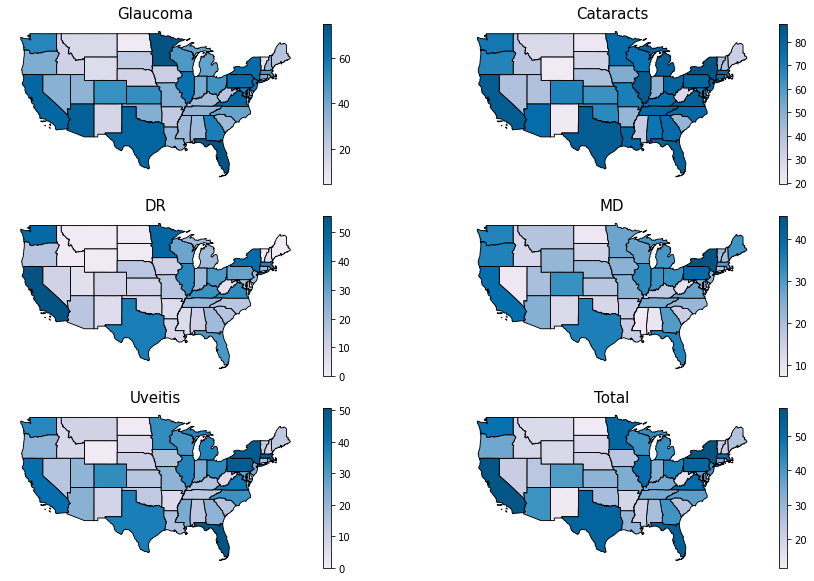

In [591]:
#GLAUCOMA
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15, 10))
ax1.axis('off')
ax1.set_title("Glaucoma", fontdict={'fontsize': '15', 'fontweight' : '3'})
states.plot(column="glaucoma_interest",
        cmap= new_cmap,
        linewidth=0.9,
        ax=ax1,
        edgecolor='0',
        legend=True)


#CATARACT
ax2.axis('off')
ax2.set_title("Cataracts", fontdict={'fontsize': '15', 'fontweight' : '3'})
states.plot(column="cataract_interest",
        cmap=new_cmap,
        linewidth=0.9,
        ax=ax2,
        edgecolor='0',
        legend=True)


#DR
ax3.axis('off')
ax3.set_title("DR", fontdict={'fontsize': '15', 'fontweight' : '3'})
states.plot(column="diabetic retinopathy_interest",
        cmap= new_cmap,
        linewidth=0.9,
        ax=ax3,
        edgecolor='0',
        legend=True)



#MD
ax4.axis('off')
ax4.set_title("MD", fontdict={'fontsize': '15', 'fontweight' : '3'})
states.plot(column="macular degeneration_interest",
        cmap=new_cmap,
        linewidth=0.9,
        ax=ax4,
        edgecolor='0',
        legend=True)


#UVEITIS
ax5.axis('off')
ax5.set_title("Uveitis", fontdict={'fontsize': '15', 'fontweight' : '3'})
states.plot(column="uveitis_interest",
        cmap= new_cmap,
        linewidth=0.9,
        ax=ax5,
        edgecolor='0',
        legend=True)




#ALL
ax6.axis('off')
ax6.set_title("Total", fontdict={'fontsize': '15', 'fontweight' : '3'})
states.plot(column="Interest_21",
        cmap=new_cmap,
        linewidth=0.9,
        ax=ax6,
        edgecolor='0',
        legend=True)



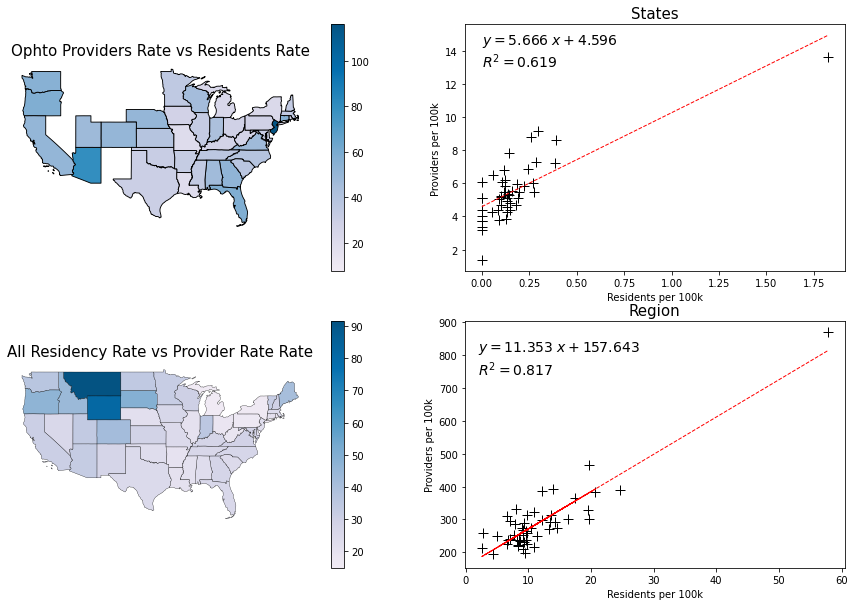

In [592]:
fig, ((ax1, ax3), (ax2, ax4)) = plot_us(states, regions, "Provider_Rate_Ratio_Optho", "Optho_residents_Per_100k", "Rate_100k_21_Ophtho", new_cmap, 'Ophto Providers Rate vs Residents Rate', 'Residents per 100k', 'Providers per 100k', 0, 13, 2, 850, region_map="Provider_Ratio_All", region_x = "All_residents_Per_100k", region_y="Rate_100k_22_All", region_title='All Residency Rate vs Provider Rate Rate')

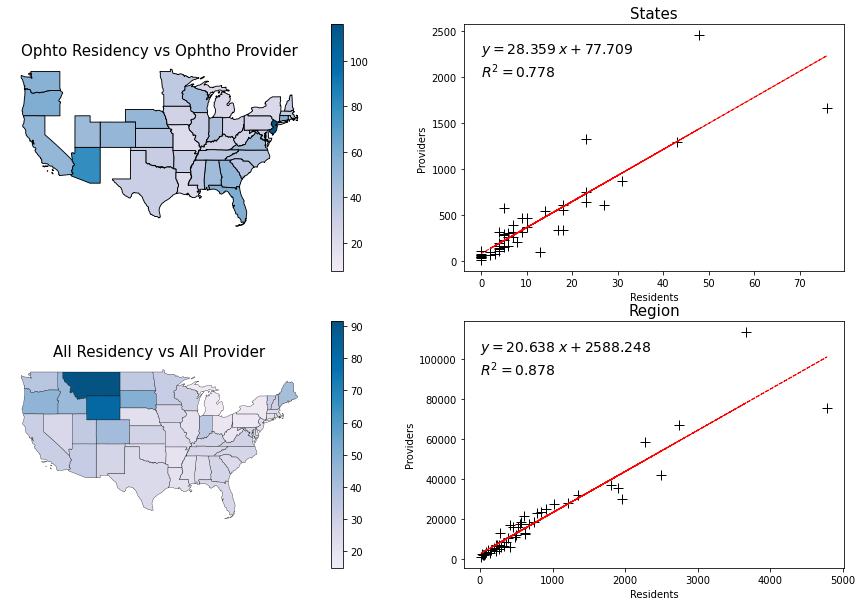

In [593]:
fig, ((ax1, ax3), (ax2, ax4)) = plot_us(states, regions, "Provider_Ratio_Optho", "Ophtho_Residents", "Ophthalmologists_21", new_cmap, 'Ophto Residency vs Ophtho Provider', 'Residents', 'Providers', 0, 2000, 0, 110000, region_map="Provider_Ratio_All", region_x = "All", region_y="MD_22", region_title='All Residency vs All Provider')

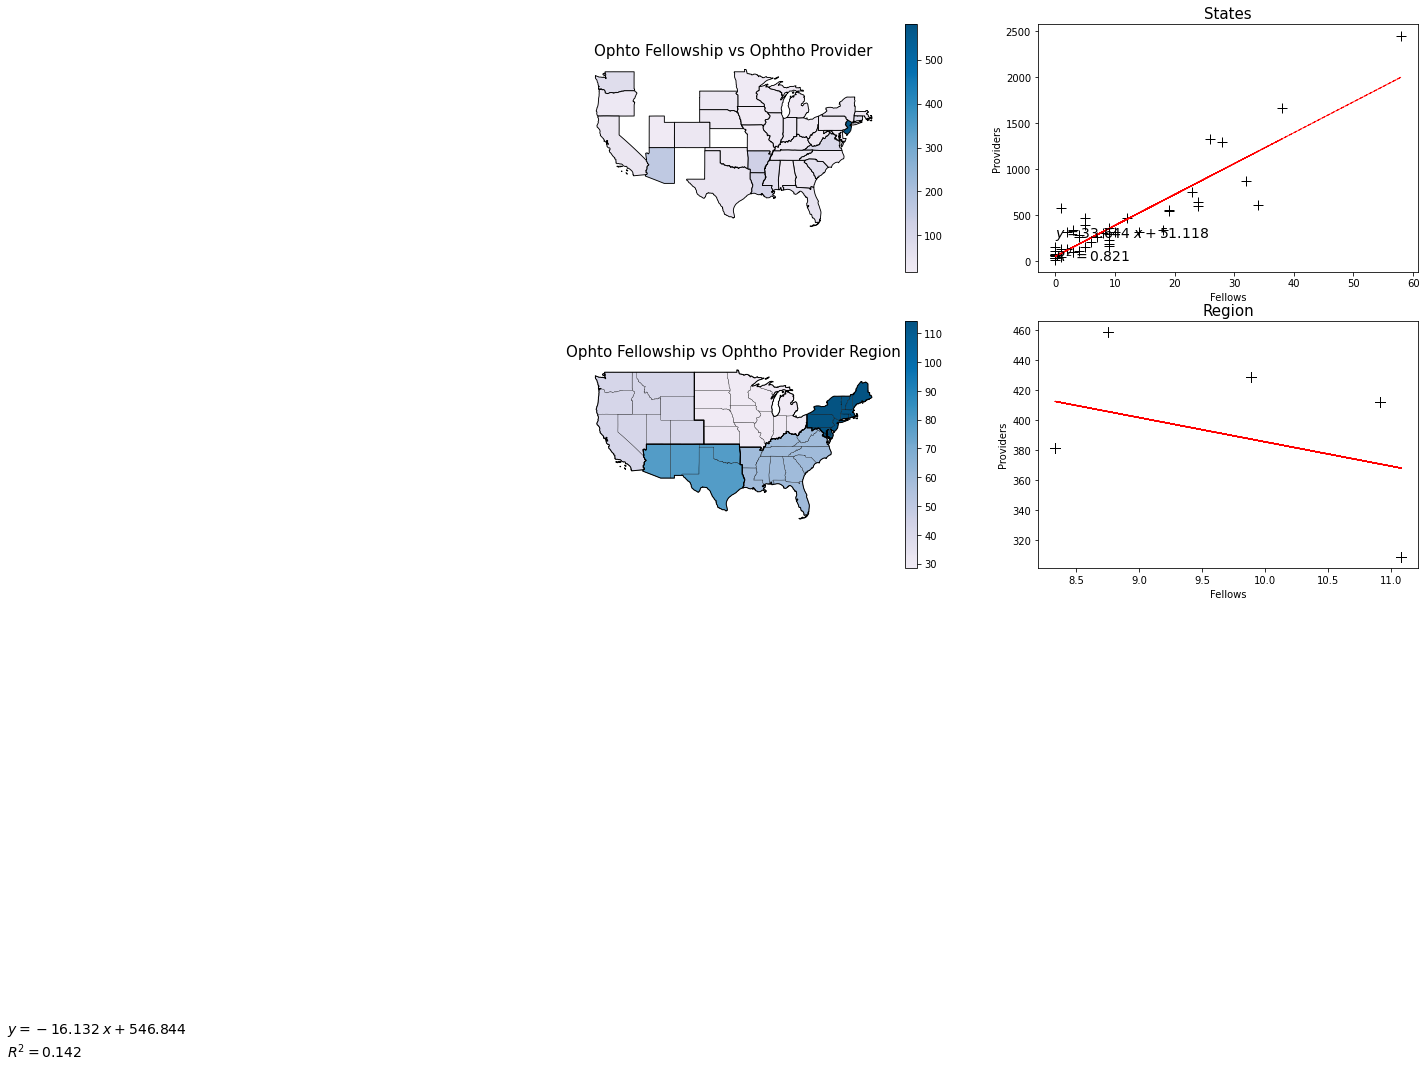

In [594]:
fig, ((ax1, ax3), (ax2, ax4)) = plot_us(states, regions, "Fellow_Ratio_Optho", "Total_Fellowship", "Ophthalmologists_21", new_cmap, 'Ophto Fellowship vs Ophtho Provider', 'Fellows', 'Providers', 0, 0, 0, 0) 

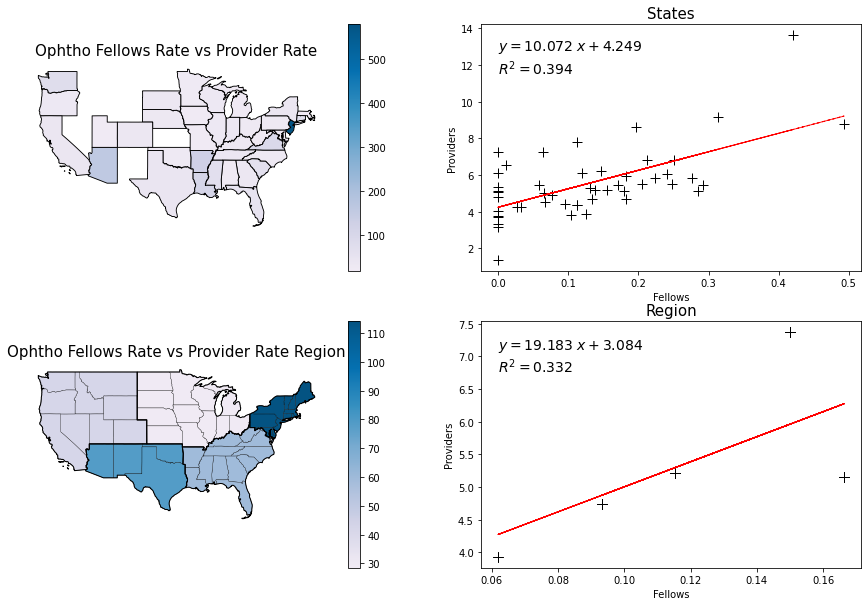

In [595]:
fig, ((ax1, ax3), (ax2, ax4)) = plot_us(states, regions, "Fellow_Rate_Ratio_Optho", "Total_Per_100k", "Rate_100k_21_Ophtho", new_cmap, 'Ophtho Fellows Rate vs Provider Rate', 'Fellows', 'Providers', 0, 11.5, 0.062, 7.3) 

Text(11, 45, '$y=0.712\\;x-13.790$\n$R^2 = 0.569$')

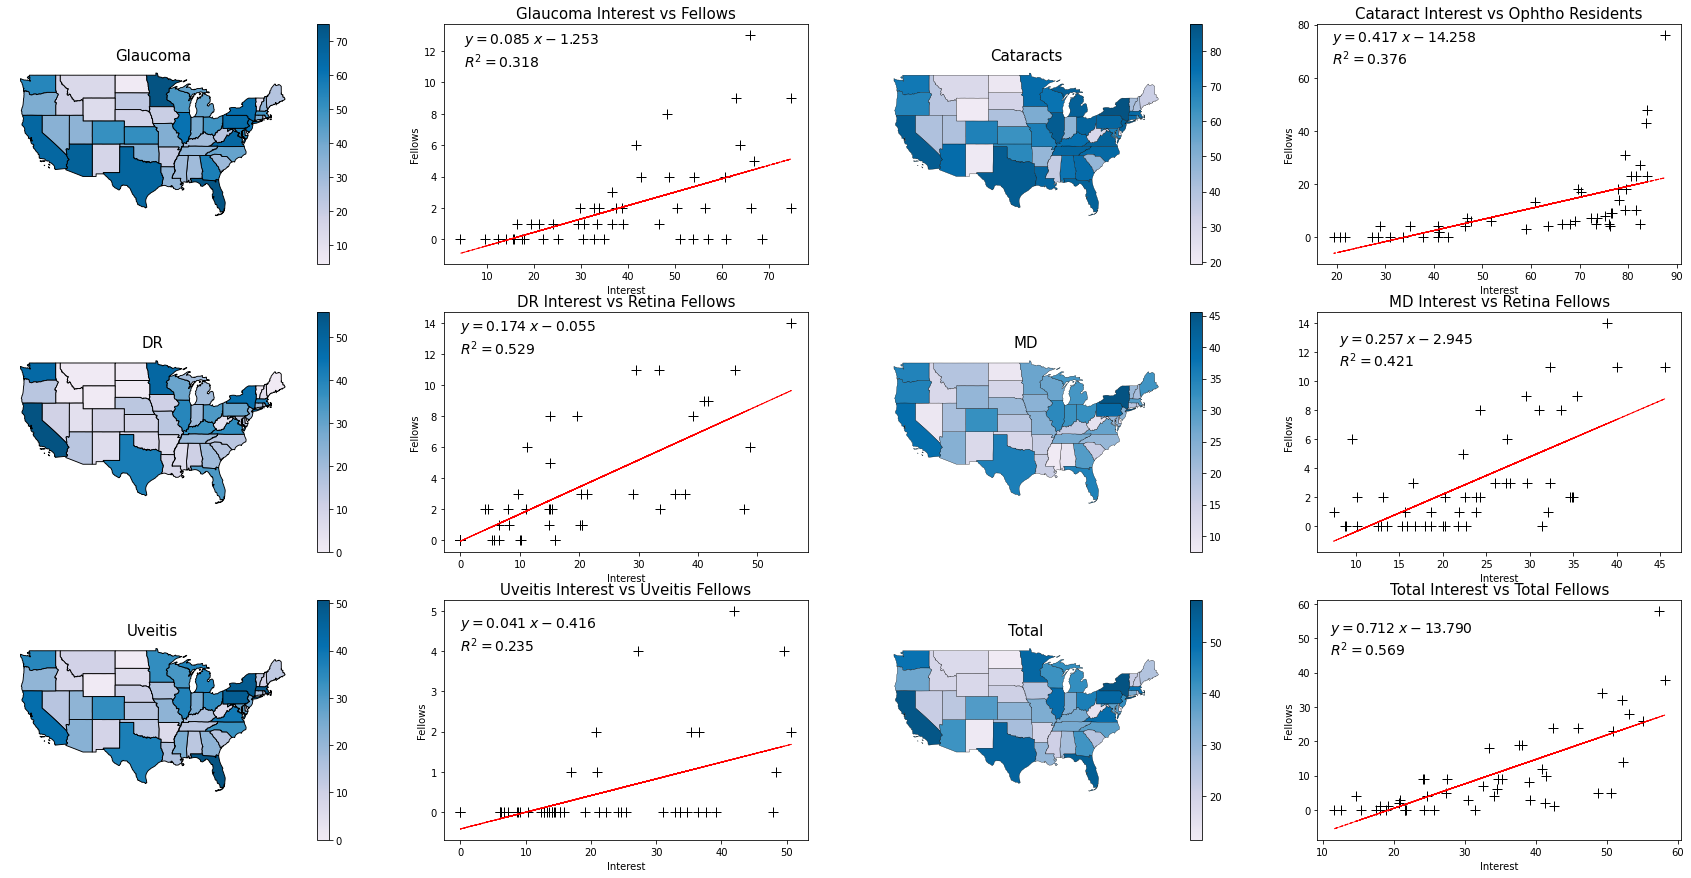

In [596]:
# glaucoma_interest
# cataract_interest
# diabetic retinopathy_interest
# macular degeneration_interest
# uveitis_interest


# pediatric-ophthalmology_fellowship
# cornea-disease_fellowship
# neuro-ophthalmology_fellowship
# Total_fellowship
# glaucoma_fellowship
# cornea-disease-surgery_fellowship
# ocular-oncology_fellowship
# oncology-pathology_fellowship
# surgical-retina-vitreous_fellowship
# uveitis_fellowship
# ophthalmic-pathology_fellowship
# medical-retina_fellowship


#GLAUCOMA
fig, ((ax1, ax1b, ax2, ax2b), (ax3, ax3b, ax4, ax4b), (ax5, ax5b, ax6, ax6b)) = plt.subplots(3, 4, figsize=(30, 15))
ax1.axis('off')
ax1.set_title("Glaucoma", fontdict={'fontsize': '15', 'fontweight' : '3'})
states.plot(column="glaucoma_interest",
        cmap= new_cmap,
        linewidth=0.9,
        ax=ax1,
        edgecolor='0',
        legend=True)

ax1b.set_title('Glaucoma Interest vs Fellows', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax1b.set_xlabel("Interest")
ax1b.set_ylabel("Fellows")
x = states["glaucoma_interest"]
y = states["glaucoma_fellowship"]

ax1b.plot(x,y,"+", 
ms=10, 
mec="k",)

z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)

ax1b.plot(x, y_hat, 
"r--",
lw=1)
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
ax1b.text(5, 11, text,
fontsize=14)



#CATARACT
ax2.axis('off')
ax2.set_title("Cataracts", fontdict={'fontsize': '15', 'fontweight' : '3'})
states.plot(column="cataract_interest",
        cmap=new_cmap,
        linewidth=0.3,
        ax=ax2,
        edgecolor='0',
        legend=True)

ax2b.set_title('Cataract Interest vs Ophtho Residents', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax2b.set_xlabel("Interest")
ax2b.set_ylabel("Fellows")
x = states["cataract_interest"]
y = states["Ophtho_Residents"]

ax2b.plot(x,y,"+", 
ms=10, 
mec="k",)

z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)

ax2b.plot(x, y_hat, 
"r--",
lw=1)
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
ax2b.text(19, 65, text,
fontsize=14)

#DR
ax3.axis('off')
ax3.set_title("DR", fontdict={'fontsize': '15', 'fontweight' : '3'})
states.plot(column="diabetic retinopathy_interest",
        cmap= new_cmap,
        linewidth=0.9,
        ax=ax3,
        edgecolor='0',
        legend=True)


ax3b.set_title('DR Interest vs Retina Fellows', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax3b.set_xlabel("Interest")
ax3b.set_ylabel("Fellows")
x = states["diabetic retinopathy_interest"]
y = states["surgical-retina-vitreous_fellowship"]

ax3b.plot(x,y,"+", 
ms=10, 
mec="k",)

z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)

ax3b.plot(x, y_hat, 
"r--",
lw=1)
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
ax3b.text(0, 12, text,
fontsize=14)



#MD
ax4.axis('off')
ax4.set_title("MD", fontdict={'fontsize': '15', 'fontweight' : '3'})
states.plot(column="macular degeneration_interest",
        cmap=new_cmap,
        linewidth=0.3,
        ax=ax4,
        edgecolor='0',
        legend=True)

ax4b.set_title('MD Interest vs Retina Fellows', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax4b.set_xlabel("Interest")
ax4b.set_ylabel("Fellows")
x = states["macular degeneration_interest"]
y = states["surgical-retina-vitreous_fellowship"]

ax4b.plot(x,y,"+", 
ms=10, 
mec="k",)

z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)

ax4b.plot(x, y_hat, 
"r--",
lw=1)
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
ax4b.text(8, 11, text,
fontsize=14)






#UVEITIS
ax5.axis('off')
ax5.set_title("Uveitis", fontdict={'fontsize': '15', 'fontweight' : '3'})
states.plot(column="uveitis_interest",
        cmap= new_cmap,
        linewidth=0.9,
        ax=ax5,
        edgecolor='0',
        legend=True)


ax5b.set_title('Uveitis Interest vs Uveitis Fellows', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax5b.set_xlabel("Interest")
ax5b.set_ylabel("Fellows")
x = states["uveitis_interest"]
y = states["uveitis_fellowship"]

ax5b.plot(x,y,"+", 
ms=10, 
mec="k",)

z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)

ax5b.plot(x, y_hat, 
"r--",
lw=1)
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
ax5b.text(0, 4, text,
fontsize=14)





#ALL
ax6.axis('off')
ax6.set_title("Total", fontdict={'fontsize': '15', 'fontweight' : '3'})
states.plot(column="Interest_21",
        cmap=new_cmap,
        linewidth=0.3,
        ax=ax6,
        edgecolor='0',
        legend=True)


ax6b.set_title('Total Interest vs Total Fellows', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax6b.set_xlabel("Interest")
ax6b.set_ylabel("Fellows")
x = states["Interest_21"]
y = states["Total_Fellowship"]

ax6b.plot(x,y,"+", 
ms=10, 
mec="k",)

z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)

ax6b.plot(x, y_hat, 
"r--",
lw=1)
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
ax6b.text(11, 45, text,
fontsize=14)

In [597]:
'''#GLAUCOMA
fig, ((ax1, ax1b, ax2, ax2b), (ax3, ax3b, ax4, ax4b), (ax5, ax5b, ax6, ax6b)) = plt.subplots(3, 4, figsize=(30, 15))
ax1.axis('off')
ax1.set_title("Glaucoma", fontdict={'fontsize': '15', 'fontweight' : '3'})
states.plot(column="glaucoma_interest",
        cmap= new_cmap,
        linewidth=0.9,
        ax=ax1,
        edgecolor='0',
        legend=True)

ax1b.set_title('Glaucoma Interest vs Fellows', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax1b.set_xlabel("Interest")
ax1b.set_ylabel("Fellows")
x = states["glaucoma_interest"]
y = states["Glaucoma_Per_100k"]

ax1b.plot(x,y,"+", 
ms=10, 
mec="k",)

z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)

ax1b.plot(x, y_hat, 
"r--",
lw=1)
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
ax1b.text(0, 0, text,
fontsize=14)



#CATARACT
ax2.axis('off')
ax2.set_title("Cataracts", fontdict={'fontsize': '15', 'fontweight' : '3'})
states.plot(column="cataract_interest",
        cmap=new_cmap,
        linewidth=0.3,
        ax=ax2,
        edgecolor='0',
        legend=True)

ax2b.set_title('Cataract Interest vs Ophtho Residents', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax2b.set_xlabel("Interest")
ax2b.set_ylabel("Fellows")
x = states["cataract_interest"]
y = states["Optho_residents_Per_100k"]

ax2b.plot(x,y,"+", 
ms=10, 
mec="k",)

z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)

ax2b.plot(x, y_hat, 
"r--",
lw=1)
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
ax2b.text(0, 0, text,
fontsize=14)

#DR
ax3.axis('off')
ax3.set_title("DR", fontdict={'fontsize': '15', 'fontweight' : '3'})
states.plot(column="diabetic retinopathy_interest",
        cmap= new_cmap,
        linewidth=0.9,
        ax=ax3,
        edgecolor='0',
        legend=True)


ax3b.set_title('DR Interest vs Retina Fellows', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax3b.set_xlabel("Interest")
ax3b.set_ylabel("Fellows")
x = states["diabetic retinopathy_interest"]
y = states["Retina_Per_100k"]

ax3b.plot(x,y,"+", 
ms=10, 
mec="k",)

z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)

ax3b.plot(x, y_hat, 
"r--",
lw=1)
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
ax3b.text(0, 0, text,
fontsize=14)



#MD
ax4.axis('off')
ax4.set_title("MD", fontdict={'fontsize': '15', 'fontweight' : '3'})
states.plot(column="macular degeneration_interest",
        cmap=new_cmap,
        linewidth=0.3,
        ax=ax4,
        edgecolor='0',
        legend=True)

ax4b.set_title('MD Interest vs Retina Fellows', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax4b.set_xlabel("Interest")
ax4b.set_ylabel("Fellows")
x = states["macular degeneration_interest"]
y = states["Retina_Per_100k"]

ax4b.plot(x,y,"+", 
ms=10, 
mec="k",)

z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)

ax4b.plot(x, y_hat, 
"r--",
lw=1)
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
ax4b.text(0, 0, text,
fontsize=14)






#UVEITIS
ax5.axis('off')
ax5.set_title("Uveitis", fontdict={'fontsize': '15', 'fontweight' : '3'})
states.plot(column="uveitis_interest",
        cmap= new_cmap,
        linewidth=0.9,
        ax=ax5,
        edgecolor='0',
        legend=True)


ax5b.set_title('Uveitis Interest vs Uveitis Fellows', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax5b.set_xlabel("Interest")
ax5b.set_ylabel("Fellows")
x = states["uveitis_interest"]
y = states["Uveitis_Per_100k"]

ax5b.plot(x,y,"+", 
ms=10, 
mec="k",)

z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)

ax5b.plot(x, y_hat, 
"r--",
lw=1)
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
ax5b.text(0, 0, text,
fontsize=14)





#ALL
ax6.axis('off')
ax6.set_title("Total", fontdict={'fontsize': '15', 'fontweight' : '3'})
states.plot(column="Interest_21",
        cmap=new_cmap,
        linewidth=0.3,
        ax=ax6,
        edgecolor='0',
        legend=True)


ax6b.set_title('Uveitis Interest vs Uveitis Fellows', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax6b.set_xlabel("Interest")
ax6b.set_ylabel("Fellows")
x = states["Interest_21"]
y = states["Total_Per_100k"]

ax6b.plot(x,y,"+", 
ms=10, 
mec="k",)

z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)

ax6b.plot(x, y_hat, 
"r--",
lw=1)
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
ax6b.text(0, 0, text,
fontsize=14)'''

'#GLAUCOMA\nfig, ((ax1, ax1b, ax2, ax2b), (ax3, ax3b, ax4, ax4b), (ax5, ax5b, ax6, ax6b)) = plt.subplots(3, 4, figsize=(30, 15))\nax1.axis(\'off\')\nax1.set_title("Glaucoma", fontdict={\'fontsize\': \'15\', \'fontweight\' : \'3\'})\nstates.plot(column="glaucoma_interest",\n        cmap= new_cmap,\n        linewidth=0.9,\n        ax=ax1,\n        edgecolor=\'0\',\n        legend=True)\n\nax1b.set_title(\'Glaucoma Interest vs Fellows\', fontdict={\'fontsize\': \'15\', \'fontweight\' : \'3\'})\nax1b.set_xlabel("Interest")\nax1b.set_ylabel("Fellows")\nx = states["glaucoma_interest"]\ny = states["Glaucoma_Per_100k"]\n\nax1b.plot(x,y,"+", \nms=10, \nmec="k",)\n\nz = np.polyfit(x, y, 1)\ny_hat = np.poly1d(z)(x)\n\nax1b.plot(x, y_hat, \n"r--",\nlw=1)\ntext = f"$y={z[0]:0.3f}\\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"\nax1b.text(0, 0, text,\nfontsize=14)\n\n\n\n#CATARACT\nax2.axis(\'off\')\nax2.set_title("Cataracts", fontdict={\'fontsize\': \'15\', \'fontweight\' : \'3\'})\nstates.plot

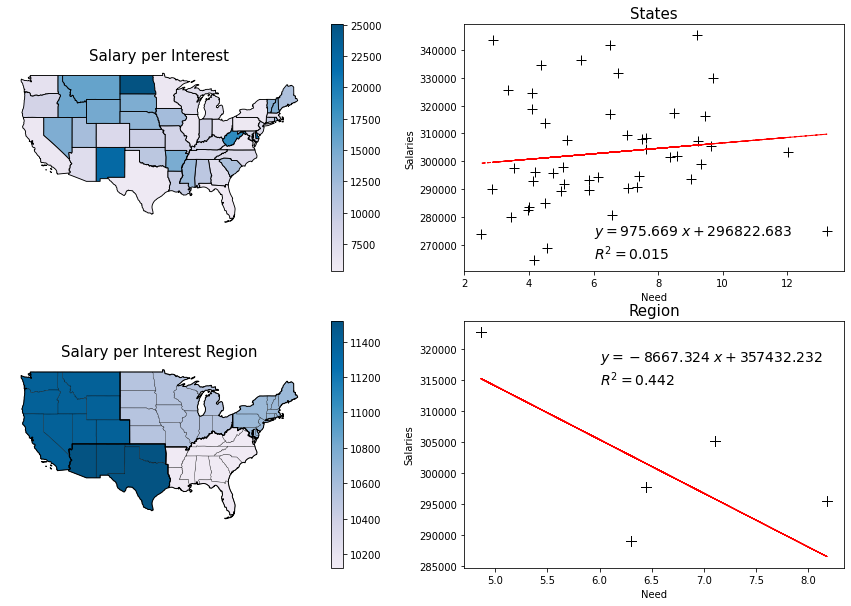

In [598]:
fig = plot_us(states, regions, "Need_Salaries", "Need_21", "Salaries", new_cmap, 'Salary per Interest', 'Need', 'Salaries', 6, 265000, 6, 320000)

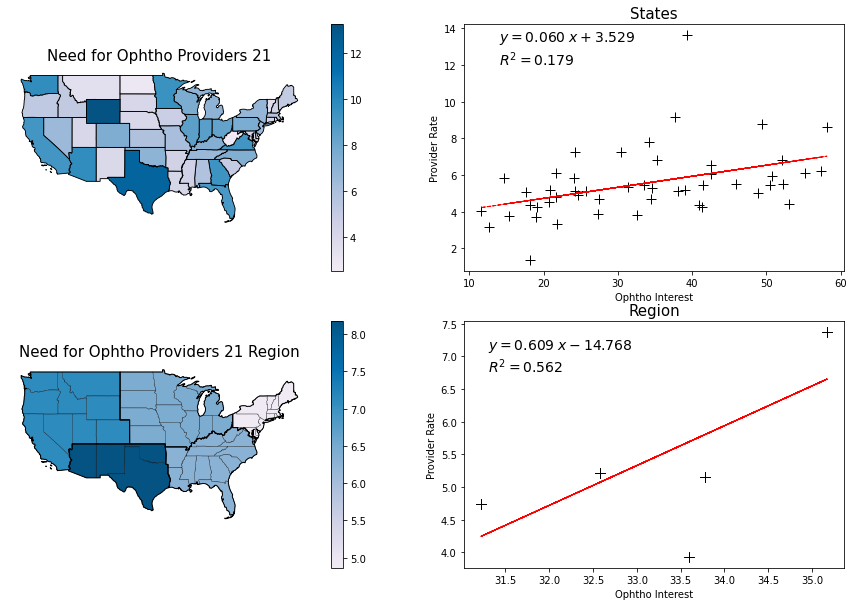

In [599]:
fig = plot_us(states, regions, "Need_21", "Interest_21", "Rate_100k_21_Ophtho", new_cmap, 'Need for Ophtho Providers 21', 'Ophtho Interest', 'Provider Rate', 14, 12, 31.3, 7.3)

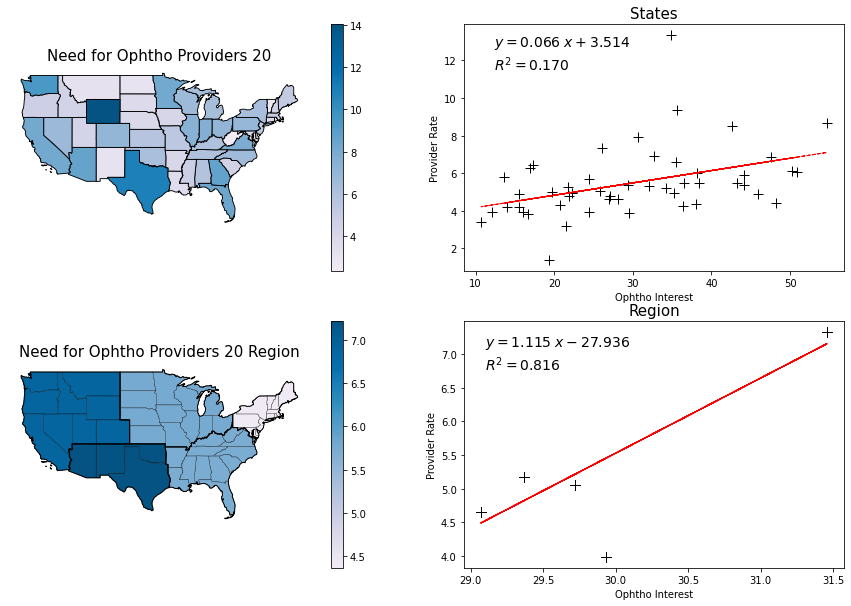

In [600]:
fig = plot_us(states, regions, "Need_20", "Interest_20", "Rate_100k_20_Ophtho", new_cmap, 'Need for Ophtho Providers 20', 'Ophtho Interest', 'Provider Rate', 12.3, 11.5, 29.1, 7.3)

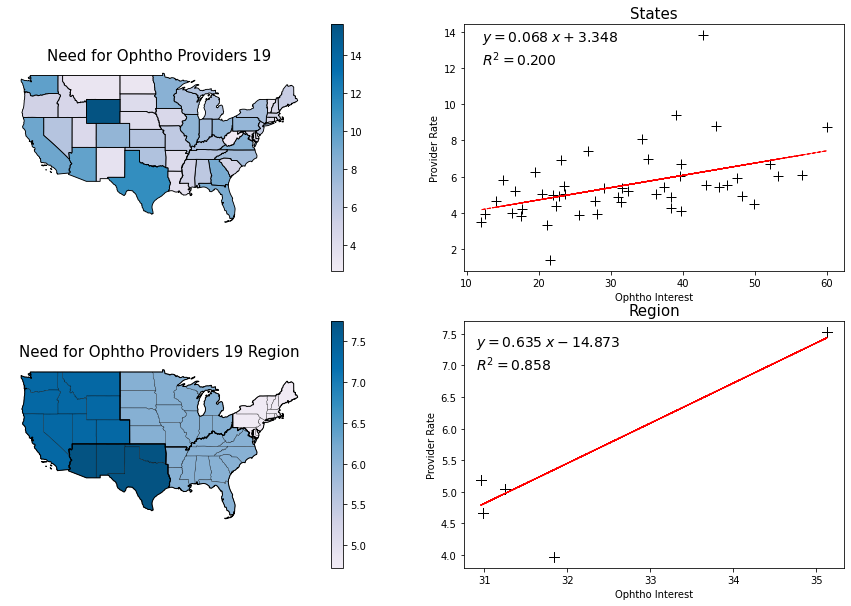

In [601]:
fig = plot_us(states, regions, "Need_19", "Interest_19", "Rate_100k_19_Ophtho", new_cmap, 'Need for Ophtho Providers 19', 'Ophtho Interest', 'Provider Rate', 12.2, 12.2, 30.9, 7.5)

In [602]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list('trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),cmap(np.linspace(minval, maxval, n)))
    return new_cmap

# arr = np.linspace(0, 50, 100).reshape((10, 10))
# fig, ax = plt.subplots(ncols=2)
# cmap = plt.get_cmap('PuBu')
cmap = plt.get_cmap('seismic')
new_cmap = truncate_colormap(cmap, 0.7, 0)
# ax[0].imshow(arr, interpolation='nearest', cmap=cmap)
# ax[1].imshow(arr, interpolation='nearest', cmap=new_cmap)
# plt.show()

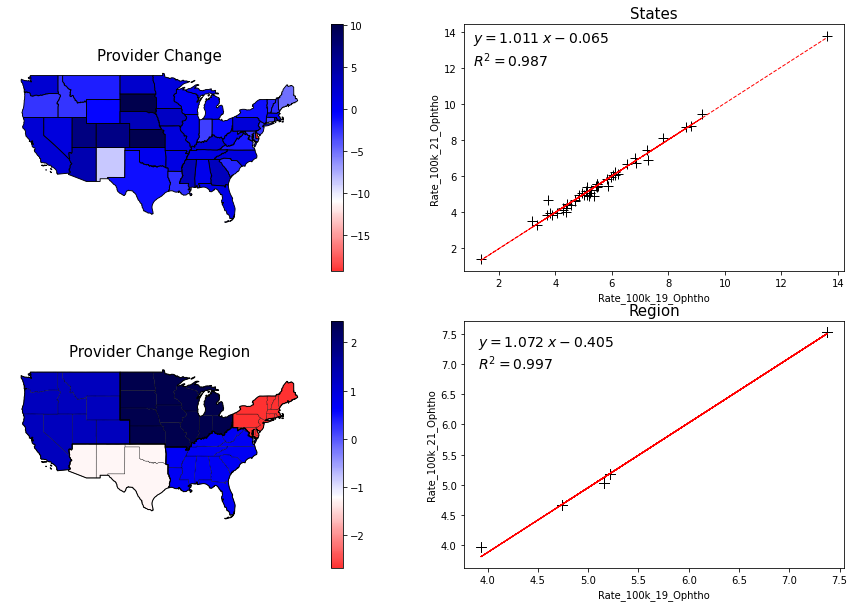

In [603]:
fig, ((ax1, ax3), (ax2, ax4)) = plot_us(states, regions, "Rate_100k_dif_21_19", "Rate_100k_21_Ophtho", "Rate_100k_19_Ophtho", new_cmap, 'Provider Change', 'Rate_100k_19_Ophtho', 'Rate_100k_21_Ophtho', 1.1, 12.1, 3.9, 7.5)

PLOTLY Graphs

In [604]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [605]:
# fig = px.choropleth(states, geojson=states.geometry, 
#                     locationmode = 'USA-states',
#                     locations=states.STUSPS, 
#                     color="Need_19",
#                     height=500,
#                     hover_name = states.NAME,
#                     hover_data = [states.Interest_19, states.Rate_100k_19_Ophtho],
#                    color_continuous_scale="Viridis")
# fig.update_geos(fitbounds="locations", visible=False)
# fig.update_layout(
#     title_text='2019'
# )
# fig.update(layout = dict(title=dict(x=0.5)))
# fig.update_layout(
#     margin={"r":0,"t":30,"l":10,"b":10},
#     coloraxis_colorbar={
#         'title':'Sum'})
# fig.show()

# fig2 = px.choropleth(states, geojson=states.geometry, 
#                     locationmode = 'USA-states',
#                     locations=states.STUSPS, 
#                     color="Need_20",
#                     height=500,
#                     hover_name = states.NAME,
#                     hover_data = [states.Interest_20, states.Rate_100k_20_Ophtho],
#                    color_continuous_scale="Viridis")
# fig2.update_geos(fitbounds="locations", visible=False)
# fig2.update_layout(
#     title_text='2020'
# )
# fig2.update(layout = dict(title=dict(x=0.5)))
# fig2.update_layout(
#     margin={"r":0,"t":30,"l":10,"b":10},
#     coloraxis_colorbar={
#         'title':'Sum'})
# fig2.show()

# fig3 = px.choropleth(states, geojson=states.geometry, 
#                     locationmode = 'USA-states',
#                     locations=states.STUSPS, 
#                     color="Need_21",
#                     height=500,
#                     hover_name = states.NAME,
#                     hover_data = [states.Interest_21, states.Rate_100k_21_Ophtho],
#                    color_continuous_scale="Viridis")
# fig3.update_geos(fitbounds="locations", visible=False)
# fig3.update_layout(
#     title_text='2021'
# )
# fig3.update(layout = dict(title=dict(x=0.5)))
# fig3.update_layout(
#     margin={"r":0,"t":30,"l":10,"b":10},
#     coloraxis_colorbar={
#         'title':'Sum'})
# fig3.show()

In [606]:
fig1 = px.scatter(states, title = "2019", x="Interest_19",y="Rate_100k_19_Ophtho", color="region", trendline="ols", trendline_scope="overall", hover_data=["NAME"])
fig1.show()
fig1.write_html('Figures/2019.html')
fig2 = px.scatter(states, title = "2020", x="Interest_20",y="Rate_100k_20_Ophtho", color="region", trendline="ols", trendline_scope="overall", hover_data=["NAME"])
fig2.show()
fig2.write_html('Figures/2020.html')
fig3 = px.scatter(states, title = "2021", x="Interest_21",y="Rate_100k_21_Ophtho", color="region", trendline="ols", trendline_scope="overall", hover_data=["NAME"])
fig3.show()
fig3.write_html('Figures/2021.html')
fig4 = px.scatter(states, title = "Ophtho_Residents", x="Ophtho_Residents",y="Ophthalmologists_21", color="region", trendline="ols", trendline_scope="overall", hover_data=["NAME"])
fig4.show()
fig4.write_html('Figures/Residents.html')
